In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import dates
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [51]:
# Workflow as given in l3 output
workflow = 'IR'

# Level3 filename (input)
level3_file = '../processed_data/EUREC4A_ManualClassifications_l3_{workflow}.zarr'.format(workflow=workflow)

# DSHIP Meteor (input)
meteor_dship_file = '/Users/haukeschulz/Documents/EUREC4A/Radiosoundings/EUREC4Asoundings/EUREC4A_Meteor_DSHIP.nc'

# Figure directory (output)
outdir = '../figures/'

In [52]:
ds = xr.open_zarr(level3_file)

In [53]:
color_dict = {'Flowers':'#2281BB',
              'Fish': '#93D2E2',
              'Gravel': '#3EAE47',
              'Sugar': '#A1D791'}

In [54]:
ds

<xarray.Dataset>
Dimensions:    (date: 47, latitude: 1500, longitude: 2200, pattern: 4)
Coordinates:
  * date       (date) datetime64[ns] 2020-01-07 2020-01-08 ... 2020-02-22
  * latitude   (latitude) float64 20.0 19.99 19.98 19.97 ... 5.03 5.02 5.01 5.0
  * longitude  (longitude) float64 -62.0 -61.99 -61.98 ... -40.02 -40.01 -40.0
  * pattern    (pattern) object 'Sugar' 'Flowers' 'Fish' 'Gravel'
Data variables:
    freq       (date, longitude, latitude, pattern) float64 dask.array<shape=(47, 2200, 1500, 4), chunksize=(1, 2200, 1500, 4)>
    nb_users   (date) float64 dask.array<shape=(47,), chunksize=(1,)>
Attributes:
    author:          Hauke Schulz (hauke.schulz@mpimet.mpg.de)
    created_on:      2020-06-10 00:43 UTC
    created_with:    create_level3.py with its last modification on Tue Jun  ...
    description:     Level-3: daily classification frequency
    institute:       Max Planck Institut für Meteorologie, Germany
    python_version:  3.6.7 | packaged by conda-forge | (defa

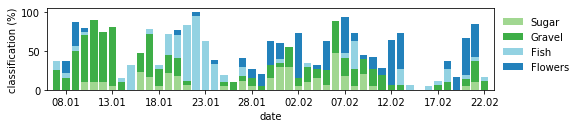

In [55]:
frequency = np.zeros((len(ds.date)))

fig, ax = plt.subplots(figsize=(8,1.5))

for p in ['Sugar', 'Gravel', 'Fish', 'Flowers']:
    data = ds.freq.interp(latitude=13.1626389, longitude=-059.4287500).sel(pattern=p).values *100
    data[np.isnan(data)] = 0
    ax.bar(dates.date2num(ds.date), data, label=p, bottom=frequency, color=color_dict[p])
    frequency += data
    hfmt = dates.DateFormatter('%d.%m')
    ax.xaxis.set_major_locator(dates.DayLocator(interval=5))
    ax.xaxis.set_major_formatter(hfmt)
plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel('date')
plt.ylabel('classification (%)')
plt.xlim(dt.datetime(2020,1,6), dt.datetime(2020,2,23))
plt.savefig(outdir+'ManualClassification_BCO_{}.pdf'.format(workflow),bbox_inches='tight')

In [56]:
ds_meteor = xr.open_dataset(meteor_dship_file)

In [57]:
ds_meteor

<xarray.Dataset>
Dimensions:  (time: 63144)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-17 ... 2020-02-29T23:59:01
    lat      (time) float64 ...
    lon      (time) float64 ...
Data variables:
    speed    (time) float64 ...
    p        (time) float64 ...
    Tport    (time) float64 ...
    Tstar    (time) float64 ...
    RHport   (time) float64 ...
    RHstar   (time) float64 ...
    DD_true  (time) float64 ...
    FF_true  (time) float64 ...
    SSTport  (time) float64 ...
    SSTstar  (time) float64 ...
Attributes:
    source:          ['/Users/haukeschulz/Documents/GitProjects/eurec4a_snd/e...
    git_version:     --
    created_with:    convert_DSHIP.py with its last modifications on Sun May ...
    created_on:      Mon May 18 23:38:57 2020
    python_version:  3.7.6 | packaged by conda-forge | (default, Mar 23 2020,...
    Conventions:     CF-1.7
    featureType:     trajectory

In [58]:
# Make coordinates data variables
ds_meteor['latitude'] = xr.DataArray(ds_meteor.lat.values, dims=['time'])
ds_meteor['longitude'] = xr.DataArray(ds_meteor.lon.values, dims=['time'])

In [59]:
ds_meteor_daily = ds_meteor.resample(time='1D').mean() # Attention, only works as long as the equator and 0 meridian are not crossed

No data found for date <xarray.DataArray 'time' ()>
array(1582416000000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-02-23
No data found for date <xarray.DataArray 'time' ()>
array(1582502400000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-02-24
No data found for date <xarray.DataArray 'time' ()>
array(1582588800000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-02-25
No data found for date <xarray.DataArray 'time' ()>
array(1582675200000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-02-26
No data found for date <xarray.DataArray 'time' ()>
array(1582761600000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-02-27
No data found for date <xarray.DataArray 'time' ()>
array(1582848000000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-02-28
No data found for date <xarray.DataArray 'time' ()>
array(158293440000

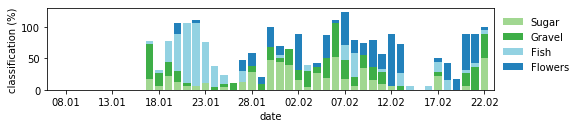

In [60]:
frequency = np.zeros((len(ds.date)))

fig, ax = plt.subplots(figsize=(8,1.5))

for d, date in enumerate(ds_meteor_daily.time):
    frequency = 0
    lat = ds_meteor_daily.latitude.sel(time=date)
    lon = ds_meteor_daily.longitude.sel(time=date)
    for p in ['Sugar', 'Gravel', 'Fish', 'Flowers']:
        try:
            data = ds.freq.interp(latitude=lat, longitude=lon).sel(date=date, pattern=p).values *100
        except KeyError:
            print('No data found for date {}'.format(date))
            break
        if np.isnan(data):
            data = 0
        ax.bar(dates.date2num(date), data, label=p, bottom=frequency, color=color_dict[p])
        hfmt = dates.DateFormatter('%d.%m')
        ax.xaxis.set_major_locator(dates.DayLocator(interval=5))
        ax.xaxis.set_major_formatter(hfmt)
        frequency += data
    if d == 0:
        plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel('date')
plt.ylabel('classification (%)')
plt.xlim(dt.datetime(2020,1,6), dt.datetime(2020,2,23))
plt.savefig(outdir+'ManualClassification_Meteor_{}.pdf'.format(workflow),bbox_inches='tight')

In [61]:
pwd

'/Users/haukeschulz/Documents/EUREC4A/EUREC4A_CloudClassification/notebooks'

In [62]:
!which python

/Users/haukeschulz/anaconda3/bin/python


## Atalante

In [63]:
import pandas as pd
import datetime as dt

In [64]:
def date_parser(d):
    print(d)
    date = pd.datetime.strptime(d, '%Y-%m-%d %H:%M:%S')
    return date

In [65]:
df = pd.read_csv('/Users/haukeschulz/Downloads/atalante_traj_gosud3_2020.txt',
                 delim_whitespace=True,
                 names=['date', 'time', 'longitude', 'latitude', 'unknown1', 'unknown2', 'unknown3'],
                 parse_dates=False
                )

In [66]:
times = pd.to_datetime(df.date + ' ' + df.time, format='%Y-%m-%d %H:%M:%S')
df.set_index(times, inplace=True)
# and maybe for cleanup
df = df.drop(['date','time'], axis=1)

In [67]:
df_atalante_daily = df.resample('1D').mean()

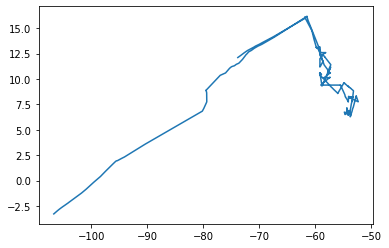

In [68]:
plt.plot(df.longitude, df.latitude)

In [69]:
ds_atalante_daily = xr.Dataset.from_dataframe(df_atalante_daily)

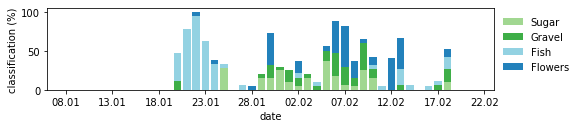

In [70]:
frequency = np.zeros((len(ds.date)))

fig, ax = plt.subplots(figsize=(8,1.5))

for d, date in enumerate(ds_atalante_daily.sel(index=slice(dt.datetime(2020,1,20),dt.datetime(2020,2,18))).index):
    frequency = 0
    lat = ds_atalante_daily.latitude.sel(index=date)
    lon = ds_atalante_daily.longitude.sel(index=date)
    if np.isnan(lat) or np.isnan(lon):
        print('Position contains nan on {}'.format(date.values))
        continue
    for p in ['Sugar', 'Gravel', 'Fish', 'Flowers']:
        try:
            data = ds.freq.sel(date=date, pattern=p).interp(coords={'latitude':lat, 'longitude':lon}, kwargs={'bounds_error':True}).values *100
        except KeyError:
            print('No data found for date {}'.format(date.values))
            break
        except ValueError:
            print('Platform is outside of domain on {}: {},{}'.format(date.values, lat.values, lon.values))
            break
        if np.isnan(data):
            data = 0
        ax.bar(dates.date2num(date), data, label=p, bottom=frequency, color=color_dict[p])
        hfmt = dates.DateFormatter('%d.%m')
        ax.xaxis.set_major_locator(dates.DayLocator(interval=5))
        ax.xaxis.set_major_formatter(hfmt)
        frequency += data
    if d == 0:
        plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel('date')
plt.ylabel('classification (%)')
plt.xlim(dt.datetime(2020,1,6), dt.datetime(2020,2,23))
plt.savefig(outdir+'ManualClassification_Atalante_{}.pdf'.format(workflow),bbox_inches='tight')

In [71]:
ds_atalante_daily.sel(index=slice(dt.datetime(2020,1,20),dt.datetime(2020,2,18)))

<xarray.Dataset>
Dimensions:    (index: 30)
Coordinates:
  * index      (index) datetime64[ns] 2020-01-20 2020-01-21 ... 2020-02-18
Data variables:
    longitude  (index) float64 -61.46 -60.21 -59.33 ... -58.84 -59.7 -60.38
    latitude   (index) float64 16.07 14.29 13.04 12.23 ... 11.7 12.6 13.18 14.28
    unknown1   (index) float64 34.3 35.99 35.79 35.46 ... 35.85 35.72 35.76
    unknown2   (index) float64 27.49 27.28 27.32 27.42 ... 27.05 27.04 27.08
    unknown3   (index) float64 27.67 27.62 27.65 27.74 ... 27.39 27.37 27.42

In [20]:
ds_atalante_daily.sel(index=slice(dt.datetime(2020,1,7),dt.datetime(2020,2,22))).latitude.min()

<xarray.DataArray 'latitude' ()>
array(6.4941089595375745)